In [12]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings
import Load_Data
import Corr_Fct
import matplotlib.pyplot as plt

In [2]:
def remove_missing(df):
    """Detects and removes missing values, the function prints out how many values were deleted."""
    '''The function deletes the entire row if either the PM10 or PM2.5 value is missing.'''
    
    '''INPUT:'''
    
    '''df:              A pandas data frame containing PM2.5 and PM10 measurements for a sensor at a given time'''
    
    '''OUTPUT:'''
    
    '''A pandas data frame without missing values'''
    
    miss = np.any([pd.isna(df['measurement_PM10']),pd.isna(df['measurement_PM2.5'])],axis = 0)
    n_miss = miss.sum()
    print(n_miss,"observations with missing values were removed from the data frame")
    return df[miss == False]    


# check for outliers and filter those using different methods
def remove_outliers(df,method = "Z-score", z_val = 2.58, crit_val = [0,100], quantile = [0,0.99]):
    '''function to remove outliers following a selected method'''
    '''deletes entire row in case either Pm10 or PM2.5 values is an outlier'''
    
    '''INPUTS:'''
    
    '''df:                         Pandas Data Frame'''
    '''method:                     A string indicating which method to use for filtering the data possible options: Z-score, critical_value, quantile'''
    '''z_val:                      Z-value, default is 2.58 (only standardised values between -1.96 and 1.96 are kept). type = byte.'''
    '''crit_val:                   List of lower and upper bound to filter values. Type: list, default: [0,100]'''
    '''quantile:                   List of lower and upper quantile to filter values. Type: list, default: [0,0.95]'''
    
    '''OUTPUTS:'''
    
    '''Pandas data frame without outliers. Prints out how many observations were removed'''
    measurement = df[['measurement_PM10','measurement_PM2.5']]
    
    if method == "Z-score":
        mean = measurement.mean()
        sd = measurement.std()
        z_score = (measurement - mean)/sd
        exclude_PM10 = np.any([z_score['measurement_PM10'] < -z_val, z_score['measurement_PM10'] > z_val],axis = 0)
        exclude_PM25 = np.any([z_score['measurement_PM2.5'] < -z_val, z_score['measurement_PM2.5'] > z_val],axis = 0)
    
    if method == "critical_value":
        if len(crit_val) < 2:
            print("ERROR: please provide a lower and an upper bound")
            return
        if len(crit_val) > 2:
            warnings.warn("Only first two elements of crit_val will be used!")
        exclude_PM10 = np.any([measurement['measurement_PM10'] < crit_val[0], measurement['measurement_PM10'] > crit_val[1]],axis = 0)
        exclude_PM25 = np.any([measurement['measurement_PM2.5'] < crit_val[0], measurement['measurement_PM2.5'] > crit_val[1]],axis = 0)
        
    if method == "quantile":
        if len(quantile) < 2:
            print("ERROR: please provide a lower and an upper quantile")
            return 
        if len(quantile) > 2:
            warnings.warn("Only first two elements of quantile will be used!")
        upper = measurement.quantile(quantile[1])
        lower = measurement.quantile(quantile[0])
        exclude_PM10 = np.any([measurement['measurement_PM10'] < lower[0], measurement['measurement_PM10'] > upper[0]],axis = 0)
        exclude_PM25 = np.any([measurement['measurement_PM2.5'] < lower[1], measurement['measurement_PM2.5'] > upper[1]],axis = 0)
            
    exclude = np.any([exclude_PM10 == True, exclude_PM25 == True],axis = 0)
    n_excluded = exclude.sum()
    print(n_excluded,"outlier observations were deleted")
    return df[exclude == False]

In [9]:
def plot_mean_pm(df, time_interval = "1Min"):
    '''plots the mean PM10 and PM2.5 concentration over the given location against time'''
    
    '''INPUTS:'''
    
    '''df:             Pandas Data Frame with PM10 and PM2.5 measurements as column'''
    '''time_interval:  A String indicating over which time interval to average the data.'''
    '''                Look at documentation of pandas.DataFrame.resample to get permissive values'''
    
    '''OUTPUTS:'''
    
    df['date_time'] = pd.to_datetime(df['time'])
    df1 = df[['date_time','measurement_PM10','measurement_PM2.5']]
    mean_data = df1.set_index('date_time').resample(time_interval, label='right').mean()
    mean_data['date_time'] = mean_data.index.strftime("%m.%d - %H:%M")
    
    plt.rc('font', size=20)          # controls default text sizes
    
    fig, ax = plt.subplots(figsize = (20,10))
    ax.plot('date_time', 'measurement_PM10', data = mean_data, color = "red")
    ax.plot('date_time', 'measurement_PM2.5', data = mean_data, color = 'blue')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.grid(True)
    ax.legend(loc = "best")
    ax.set_xlabel("Date and Time")
    ax.set_ylabel("μg/m³")
    ax.set_title("Average PM concentration over the sample area")
    fig.autofmt_xdate(rotation = 45)

In [7]:
mydf['date_time'] = pd.to_datetime(mydf['time'])
df1 = mydf[['date_time','measurement_PM10','measurement_PM2.5']]
mean_data = df1.set_index('date_time').resample("5Min", label='right').mean()
mean_data['date_time'] = mean_data.index.strftime("%m.%d - %H:%M")

In [40]:
start_time = datetime.fromisoformat("2018-06-01T00:00:00")
mydf = Load_Data.load_data(50, 50.3, 8.4, 9, start_time, 24)

In [41]:
mydf = remove_missing(mydf)
mydf = remove_outliers(mydf)

30848 observations with missing values were removed from the data frame
646 outlier observations were deleted


In [43]:
mydf_corr = Corr_Fct.corr_coeff(mydf)
print(mydf_corr)

0.8328350688903466


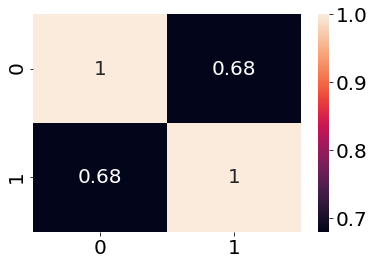

In [25]:
mydf_corrmat = Corr_Fct.corr_matrix(mydf, plot = True)

In [113]:
print(mydf_corrmat)

[[1.         0.08256485]
 [0.08256485 1.        ]]


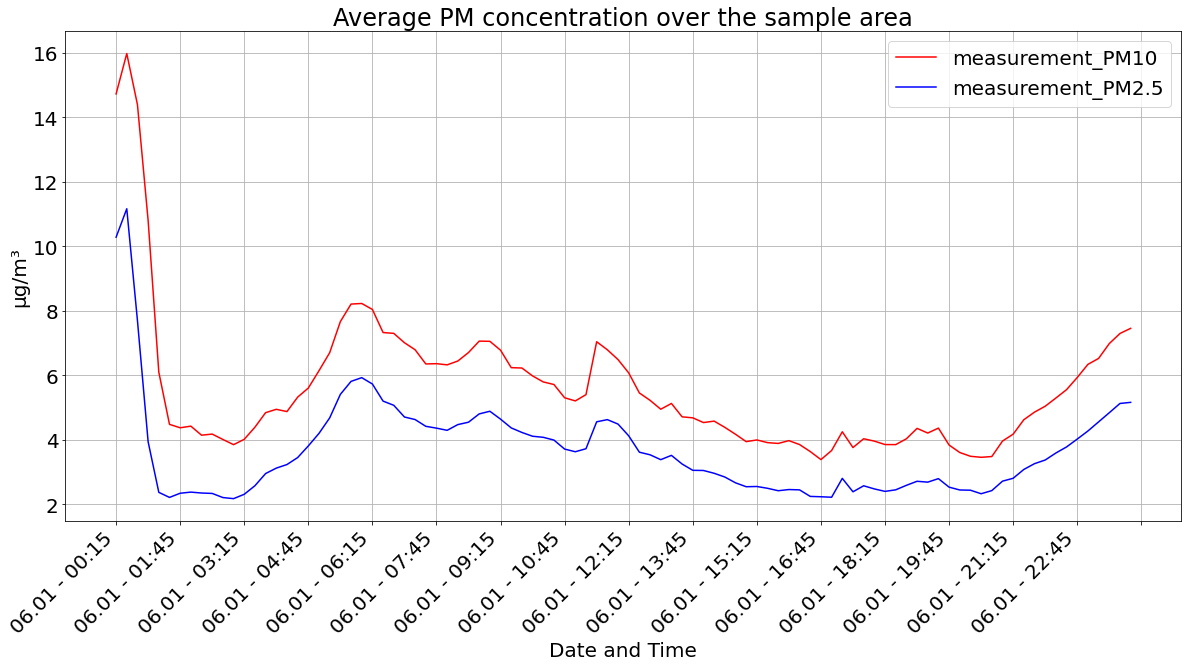

In [42]:
plot_mean_pm(mydf, time_interval = "15Min")